# Wavelets parameters

- author Sylvie Dagoret-Campagne
- creation date August 14th 2020

In [608]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [609]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [610]:
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [611]:
import libatmscattering as atm

In [612]:
from astroML.fourier import FT_continuous, IFT_continuous

In [613]:
from astroML.fourier import\
    FT_continuous, IFT_continuous, sinegauss, sinegauss_FT, wavelet_PSD

In [651]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.rcParams['font.size'] = 18

In [615]:
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

In [616]:
DATADIR="../../data/atm"

In [617]:
atmospheric_basename_files=os.listdir(DATADIR)

In [618]:
atmospheric_basename_files

['lsst_atm_10year_bintab.parquet',
 'lsst_atm_10year_01.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_bintab.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_bintab_small.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_03.fits',
 '.ipynb_checkpoints',
 'lsst_atm_10year_02.fits']

In [619]:
input_file=os.path.join(DATADIR,'lsst_atm_10year_bigimg.fits')

In [620]:
hdu = fits.open(input_file)

In [621]:
hdr=hdu[0].header
data=hdu[0].data

In [622]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  958                                                  
NAXIS2  =                 3651                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [623]:
NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [624]:
num=data[1:,idx_out_num]
year=data[1:,idx_out_year]
airmass=data[1:,idx_out_year]
vaod=data[1:,idx_out_vaod] # vertical aerosol depth
pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[1:,idx_out_o3]     # ozone
cld=data[1:,idx_out_cld]   # clouds (not used)

In [625]:
# Extract wavelength Wavelength
wl=data[0,idx_out_res:]
transm=data[1:,idx_out_res:]

In [626]:
NWL=wl.shape[0]

In [627]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data

In [628]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]

In [629]:
Y=np.concatenate((vaodarr,pwvarr,o3arr),axis=1)

In [630]:
indexes_selected=np.where(np.logical_and(wl>350,wl<=1100))[0]

In [631]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [632]:
len(indexes_selected)

750

In [633]:
wl=wl[indexes_selected]
transm=transm[:,indexes_selected]

In [634]:
#transm0=transm[0]*0.96
transm0=transm[0]

In [635]:
od=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
att_rayleigh=np.exp(-od)

Text(0, 0.5, 'att (mag)')

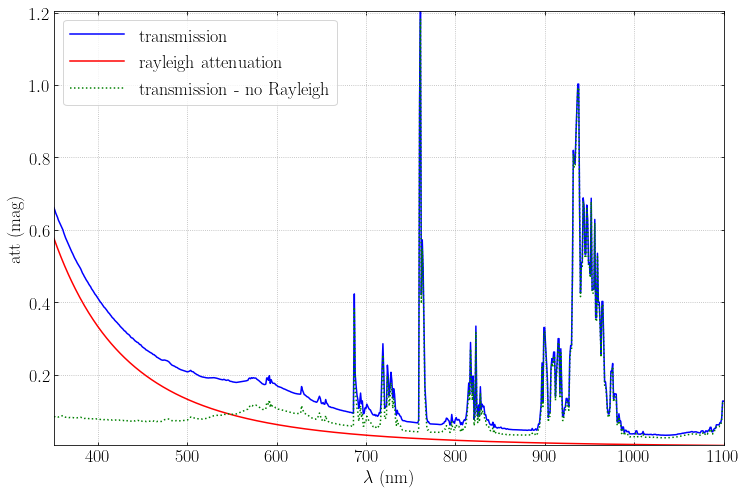

In [636]:
ax = plt.subplot(111)
ax.plot(wl,-2.5*np.log10(transm0),'b-',label="transmission")
ax.plot(wl,-2.5*np.log10(att_rayleigh),'r-',label="rayleigh attenuation")
ax.plot(wl,-2.5*np.log10(transm0/att_rayleigh),'g:',label="transmission - no Rayleigh")
ax.legend()
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("att (mag)")

# Show the wavelet PSD

In [637]:
# correction from Rayleigh
t=wl
h=-2.5*np.log10(transm0/att_rayleigh)

In [638]:
#------------------------------------------------------------
# Compute the wavelet PSD
f0 = np.linspace(0.01, 1, 100)
wPSD = wavelet_PSD(t, h, f0, Q=2)

In [639]:
themin=1e-6
themax=10.


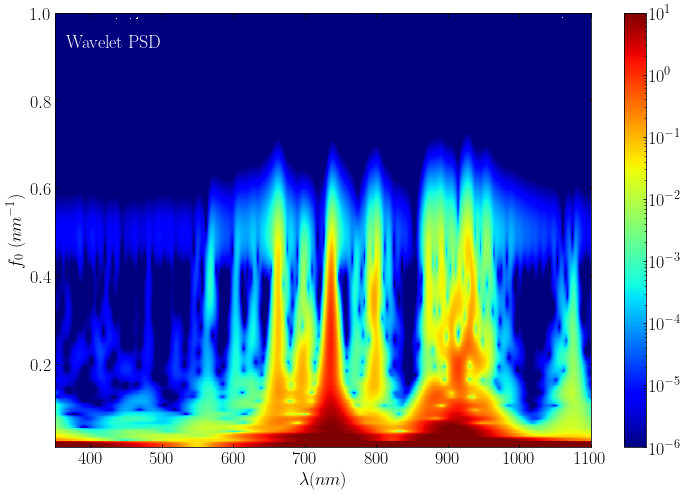

In [640]:
# The spectrogram
ax = plt.subplot(111)
#im=ax.imshow(wPSD, origin='lower', aspect='auto', norm=colors.LogNorm(vmin=wPSD.min(), vmax=wPSD.max()),cmap="jet",
#          extent=[t[0], t[-1], f0[0], f0[-1]])

im=ax.imshow(wPSD, origin='lower', aspect='auto', norm=colors.LogNorm(vmin=themin, vmax=themax),cmap="jet",
          extent=[t[0], t[-1], f0[0], f0[-1]])

ax.text(0.02, 0.95, ("Wavelet PSD"), color='w',ha='left', va='top', transform=ax.transAxes)


ax.set_xlabel('$\lambda (nm)$')
ax.set_ylabel('$f_0$  $(nm^{-1})$')
plt.colorbar(im, ax=ax)
plt.show()


In [649]:
#------------------------------------------------------------
# Compute the wavelet PSD
f0 = np.logspace(-2, 1, 200)
wPSD = wavelet_PSD(t, h, f0, Q=2)

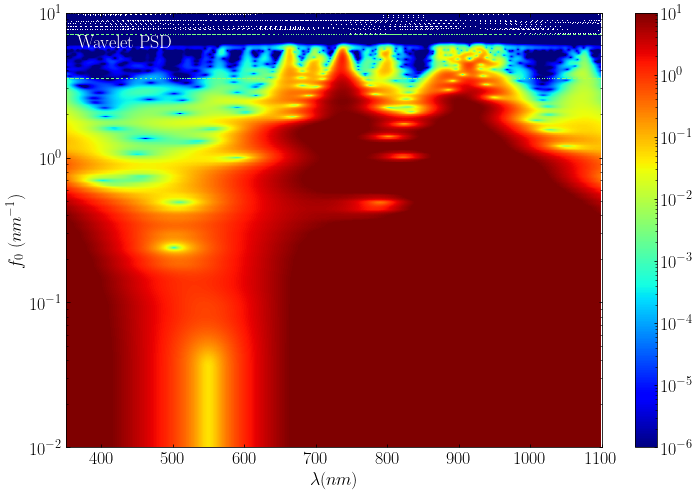

In [650]:
# Third panel: the spectrogram
ax = plt.subplot(111)
#im=ax.imshow(wPSD, origin='lower', aspect='auto',norm=colors.LogNorm(vmin=wPSD.min(), vmax=wPSD.max()),cmap="jet",
#          extent=[t[0], t[-1], f0[0], f0[-1]])

im=ax.imshow(wPSD, origin='lower', aspect='auto',norm=colors.LogNorm(vmin=themin, vmax=themax),cmap="jet",
          extent=[t[0], t[-1], f0[0], f0[-1]])

ax.text(0.02, 0.95, ("Wavelet PSD"), color='w',ha='left', va='top', transform=ax.transAxes)


ax.set_xlabel('$\lambda (nm)$')
ax.set_ylabel('$f_0$  $(nm^{-1})$')
ax.set_yscale("log")
plt.colorbar(im, ax=ax)
plt.show()


# Effect of clouds

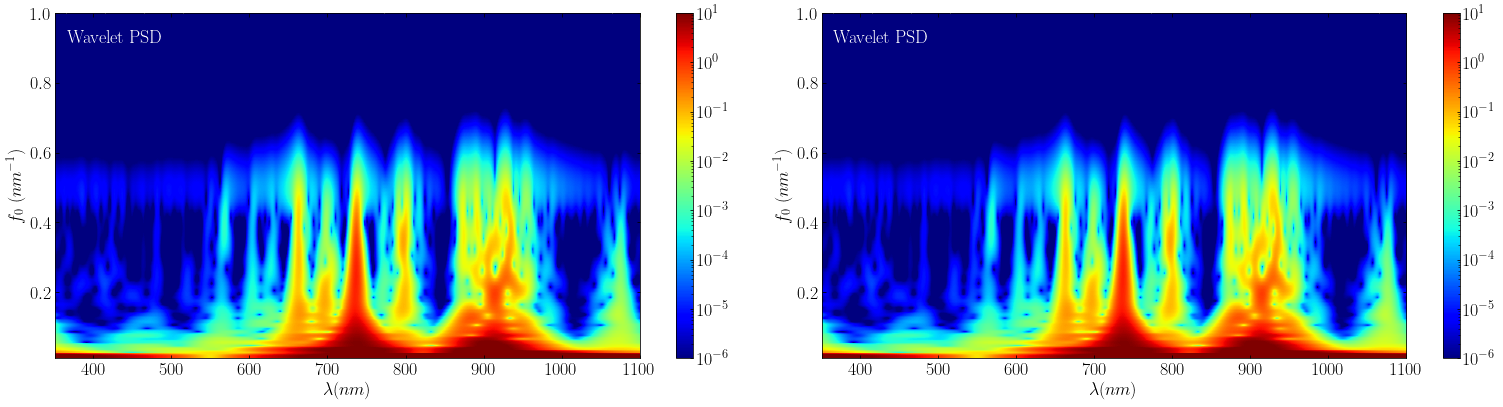

In [643]:
# The spectrogram
fig = plt.figure(figsize = (22, 6)) 


ax = plt.subplot(121)

transm0=transm[0]

themin=1e-6
themax=10.



# correction from Rayleigh
t=wl
h=-2.5*np.log10(transm0/att_rayleigh)
#------------------------------------------------------------
# Compute the wavelet PSD
f0 = np.linspace(0.01, 1, 100)
wPSD = wavelet_PSD(t, h, f0, Q=2)

#im=ax.imshow(wPSD, origin='lower', aspect='auto', norm=colors.LogNorm(vmin=wPSD.min(), vmax=wPSD.max()),cmap="jet",
#          extent=[t[0], t[-1], f0[0], f0[-1]])
im=ax.imshow(wPSD, origin='lower', aspect='auto', norm=colors.LogNorm(vmin=themin, vmax=themax),cmap="jet",
          extent=[t[0], t[-1], f0[0], f0[-1]])

ax.text(0.02, 0.95, ("Wavelet PSD"), color='w',ha='left', va='top', transform=ax.transAxes)


ax.set_xlabel('$\lambda (nm)$')
ax.set_ylabel('$f_0$  $(nm^{-1})$')
plt.colorbar(im, ax=ax)


ax = plt.subplot(122)

transm0=transm[0]*0.5
# correction from Rayleigh
t=wl
h=-2.5*np.log10(transm0/att_rayleigh)
#------------------------------------------------------------
# Compute the wavelet PSD
f0 = np.linspace(0.01, 1, 100)
wPSD = wavelet_PSD(t, h, f0, Q=2)

#im=ax.imshow(wPSD, origin='lower', aspect='auto', norm=colors.LogNorm(vmin=wPSD.min(), vmax=wPSD.max()),cmap="jet",
#          extent=[t[0], t[-1], f0[0], f0[-1]])
im=ax.imshow(wPSD, origin='lower', aspect='auto', norm=colors.LogNorm(vmin=themin, vmax=themax),cmap="jet",
          extent=[t[0], t[-1], f0[0], f0[-1]])

ax.text(0.02, 0.95, ("Wavelet PSD"), color='w',ha='left', va='top', transform=ax.transAxes)


ax.set_xlabel('$\lambda (nm)$')
ax.set_ylabel('$f_0$  $(nm^{-1})$')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


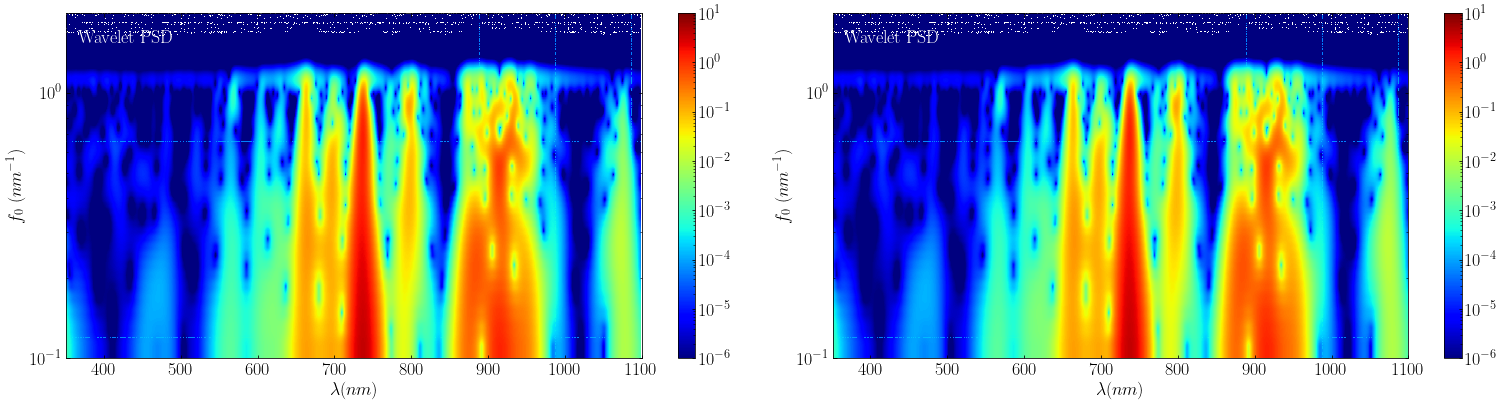

In [644]:
# The spectrogram
fig = plt.figure(figsize = (22, 6)) 


ax = plt.subplot(121)

transm0=transm[0]
# correction from Rayleigh
t=wl
h=-2.5*np.log10(transm0/att_rayleigh)
#------------------------------------------------------------
# Compute the wavelet PSD
f0 = np.logspace(-1, 0.3, 100)
wPSD = wavelet_PSD(t, h, f0, Q=2)

themin=1e-6
themax=10.


im=ax.imshow(wPSD, origin='lower', aspect='auto', norm=colors.LogNorm(vmin=themin, vmax=themax),cmap="jet",
          extent=[t[0], t[-1], f0[0], f0[-1]])

ax.text(0.02, 0.95, ("Wavelet PSD"), color='w',ha='left', va='top', transform=ax.transAxes)


ax.set_xlabel('$\lambda (nm)$')
ax.set_ylabel('$f_0$  $(nm^{-1})$')
ax.set_yscale("log")
plt.colorbar(im, ax=ax)


ax = plt.subplot(122)

transm0=transm[0]*0.5
# correction from Rayleigh
t=wl
h=-2.5*np.log10(transm0/att_rayleigh)
#------------------------------------------------------------
# Compute the wavelet PSD
f0 = np.logspace(-1, 0.3, 100)
wPSD = wavelet_PSD(t, h, f0, Q=2)

im=ax.imshow(wPSD, origin='lower', aspect='auto', norm=colors.LogNorm(vmin=themin, vmax=themax),cmap="jet",
          extent=[t[0], t[-1], f0[0], f0[-1]])

ax.text(0.02, 0.95, ("Wavelet PSD"), color='w',ha='left', va='top', transform=ax.transAxes)


ax.set_xlabel('$\lambda (nm)$')
ax.set_ylabel('$f_0$  $(nm^{-1})$')
ax.set_yscale("log")
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


In [645]:
wPSD.min()

4.968662143813014e-27

In [646]:
wPSD.max()

3.7811069182261416